<a href="https://colab.research.google.com/github/KamonohashiPerry/MachineLearning/blob/master/Kaggle_Start_Book_SampleCodes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd

In [107]:
!pip install kaggle

In [108]:
from google.colab import files
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename =  "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [109]:
!kaggle competitions list

ref                                               deadline             category            reward  teamCount  userHasEntered  
------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                  2030-01-01 00:00:00  Getting Started  Knowledge       2252           False  
titanic                                           2030-01-01 00:00:00  Getting Started  Knowledge      17295            True  
house-prices-advanced-regression-techniques       2030-01-01 00:00:00  Getting Started  Knowledge       4515            True  
connectx                                          2030-01-01 00:00:00  Getting Started  Knowledge        306           False  
nlp-getting-started                               2030-01-01 00:00:00  Getting Started      Kudos       3059           False  
competitive-data-science-predict-future-sales     2020-12-31 23:59:00  Playground           Kudos       6137   

In [110]:
!kaggle competitions download -c titanic

test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [111]:
ls

adc.json               oof_train_kfold.csv  submission.csv           test.csv
gender_submission.csv  sample_data/         submission_lightgbm.csv  train.csv


In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

In [113]:
gender_submission.head()

PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1

In [0]:
data = pd.concat([train, test], sort=False)

In [115]:
data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [0]:
# replace関数でスマートにデータの変換をしている。
data['Sex'].replace(['male', 'female'], [0, 1], inplace=True)

In [0]:
# map関数でスマートにデータの変換をしている。
data['Embarked'].fillna('S', inplace=True)
data['Embarked'] = data['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)

In [0]:
# 欠損値補完を平均値で行う際もワンライナーで。
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)

In [0]:
# 1σ区間からなる乱数を生成してそれを欠損値補完にしている。
age_avg = data['Age'].mean()
age_std = data['Age'].std()
data['Age'].fillna(np.random.randint(age_avg - age_std, age_avg + age_std), inplace=True)

In [0]:
train = data[:len(train)]
test = data[len(train):]

y_train = train['Survived']
X_train = train.drop('Survived', axis=1)
X_test = test.drop('Survived', axis=1)

In [0]:
# from sklearn.linear_model import LogisticRegression

# clf = LogisticRegression(penalty='l2', solver='sag', random_state=0)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

In [0]:
sub = pd.read_csv('gender_submission.csv')
# sub['Survived'] = list(map(int, y_pred))
# sub.to_csv('submission.csv', index=False)

## EDA

In [0]:
# pd.__version__

In [0]:
# !pip install -U pandas-profiling

In [128]:
%matplotlib inline
import pandas as pd
import pandas_profiling

train = pd.read_csv('train.csv')
train.profile_report()

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

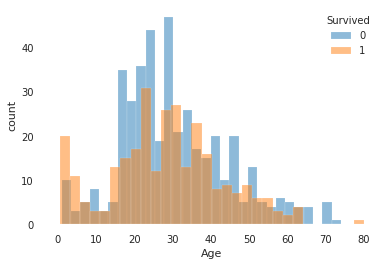

In [130]:
plt.hist(train.loc[train['Survived'] == 0, 'Age'].dropna(), bins=30, alpha=0.5, label='0')
plt.hist(train.loc[train['Survived'] == 1, 'Age'].dropna(), bins=30, alpha=0.5, label='1')
plt.xlabel('Age')
plt.ylabel('count')
plt.legend(title='Survived');

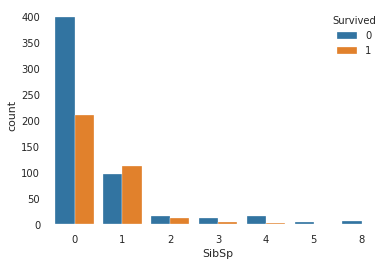

In [131]:
sns.countplot(x='SibSp', hue='Survived', data=train)
plt.legend(loc='upper right', title='Survived');

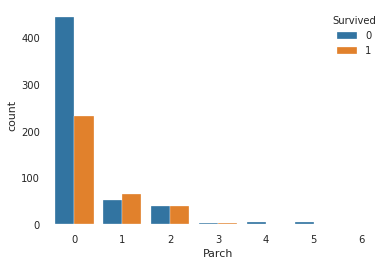

In [132]:
sns.countplot(x='Parch', hue='Survived', data=train)
plt.legend(loc='upper right', title='Survived');

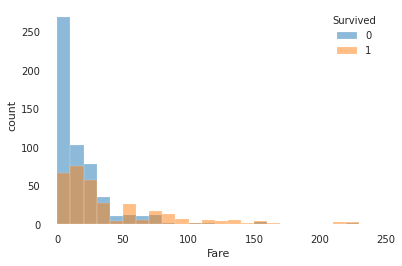

In [133]:
plt.hist(train.loc[train['Survived'] == 0, 'Fare'].dropna(), range=(0, 250), bins=25, alpha=0.5, label='0')
plt.hist(train.loc[train['Survived'] == 1, 'Fare'].dropna(), range=(0, 250), bins=25, alpha=0.5, label='1')
plt.xlabel('Fare')
plt.ylabel('count')
plt.legend(title='Survived')
plt.xlim(-5, 250);

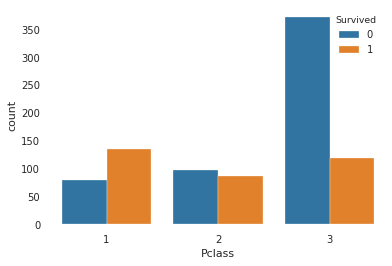

In [134]:
sns.countplot(x='Pclass', hue='Survived', data=train);

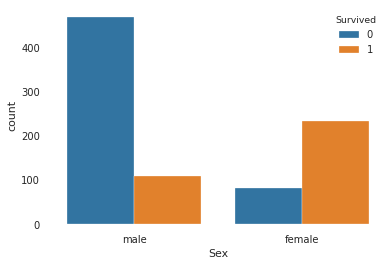

In [135]:
sns.countplot(x='Sex', hue='Survived', data=train);

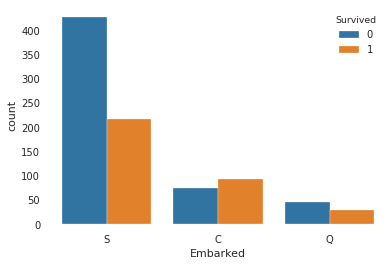

In [136]:
sns.countplot(x='Embarked', hue='Survived', data=train);

## 新しい特徴量

In [0]:
import seaborn as sns

In [0]:
data['FamilySize'] = data['Parch'] + data['SibSp'] + 1

## アルゴリズム

In [0]:
delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
data.drop(delete_columns, axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



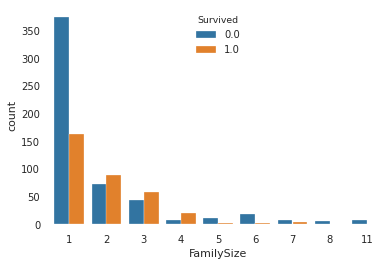

In [145]:
train['FamilySize'] = data['FamilySize'][:len(train)]
test['FamilySize'] = data['FamilySize'][len(train):]
sns.countplot(x='FamilySize', data=train, hue='Survived');

In [0]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [0]:
y_pred = (y_pred > 0.5).astype(int)
sub['Survived'] = y_pred
sub.to_csv('submission_randomforest.csv', index=False)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0, stratify=y_train)

In [158]:
import lightgbm as lgb

categorical_features = ['Pclass', 'Sex', 'Embarked']

lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)

params = {
    'objective':'binary'
}

model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=10,
                  num_boost_round=1000,
                  early_stopping_rounds=10)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.427101	valid_1's binary_logloss: 0.47927
[20]	training's binary_logloss: 0.350026	valid_1's binary_logloss: 0.445983
[30]	training's binary_logloss: 0.29973	valid_1's binary_logloss: 0.443055
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.33101	valid_1's binary_logloss: 0.438922


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



In [0]:
y_pred = (y_pred > 0.5).astype(int)
sub['Survived'] = y_pred
sub.to_csv('submission_lightgbm.csv', index=False)

## ハイパーパラメータの調整

In [0]:
!pip install optuna

In [0]:
import optuna
from sklearn.metrics import log_loss

def objective(trial):
  params = {
      'objective':'binary',
      'max_bin':trial.suggest_int('max_bin', 255, 500),
      'learning_rate':0.05,
      'num_leaves':trial.suggest_int('num_leaves', 32, 128),
  }

  lgb_train = lgb.Dataset(X_train, y_train,
                          categorical_feature=categorical_features)
  lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train,
                         categorical_feature=categorical_features)
  
  model = lgb.train(params, lgb_train,
                    valid_sets=[lgb_train, lgb_eval],
                    verbose_eval=10,
                    num_boost_round=1000,
                    early_stopping_rounds=10)
  y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
  score = log_loss(y_valid, y_pred_valid)

  return score

In [160]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:40,844] Finished trial#0 with value: 0.43651036237626356 with parameters: {'max_bin': 427, 'num_leaves': 79}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:41,099] Finished trial#1 with value: 0.43651036237626356 with parameters: {'max_bin': 372, 'num_leaves': 96}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:41,349] Finished trial#2 with value: 0.43651036237626356 with parameters: {'max_bin': 322, 'num_leaves': 99}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:41,593] Finished trial#3 with value: 0.43651036237626356 with parameters: {'max_bin': 358, 'num_leaves': 41}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:41,846] Finished trial#4 with value: 0.43651036237626356 with parameters: {'max_bin': 466, 'num_leaves': 53}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:42,094] Finished trial#5 with value: 0.43651036237626356 with parameters: {'max_bin': 497, 'num_leaves': 68}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:42,361] Finished trial#6 with value: 0.43651036237626356 with parameters: {'max_bin': 342, 'num_leaves': 102}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:42,601] Finished trial#7 with value: 0.43651036237626356 with parameters: {'max_bin': 471, 'num_leaves': 120}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:42,845] Finished trial#8 with value: 0.43651036237626356 with parameters: {'max_bin': 395, 'num_leaves': 90}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:43,086] Finished trial#9 with value: 0.43651036237626356 with parameters: {'max_bin': 448, 'num_leaves': 71}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:43,344] Finished trial#10 with value: 0.43651036237626356 with parameters: {'max_bin': 342, 'num_leaves': 78}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:43,605] Finished trial#11 with value: 0.43651036237626356 with parameters: {'max_bin': 343, 'num_leaves': 113}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:43,852] Finished trial#12 with value: 0.43651036237626356 with parameters: {'max_bin': 420, 'num_leaves': 57}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:44,103] Finished trial#13 with value: 0.43651036237626356 with parameters: {'max_bin': 332, 'num_leaves': 104}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:44,352] Finished trial#14 with value: 0.43651036237626356 with parameters: {'max_bin': 264, 'num_leaves': 52}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:44,597] Finished trial#15 with value: 0.43651036237626356 with parameters: {'max_bin': 370, 'num_leaves': 112}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:44,841] Finished trial#16 with value: 0.43651036237626356 with parameters: {'max_bin': 498, 'num_leaves': 101}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:45,084] Finished trial#17 with value: 0.43651036237626356 with parameters: {'max_bin': 334, 'num_leaves': 79}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:45,342] Finished trial#18 with value: 0.43651036237626356 with parameters: {'max_bin': 447, 'num_leaves': 114}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:45,584] Finished trial#19 with value: 0.43651036237626356 with parameters: {'max_bin': 354, 'num_leaves': 120}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:45,837] Finished trial#20 with value: 0.43651036237626356 with parameters: {'max_bin': 432, 'num_leaves': 61}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:46,089] Finished trial#21 with value: 0.43651036237626356 with parameters: {'max_bin': 402, 'num_leaves': 51}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:46,349] Finished trial#22 with value: 0.43651036237626356 with parameters: {'max_bin': 397, 'num_leaves': 71}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:46,600] Finished trial#23 with value: 0.43651036237626356 with parameters: {'max_bin': 287, 'num_leaves': 97}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:46,856] Finished trial#24 with value: 0.43651036237626356 with parameters: {'max_bin': 264, 'num_leaves': 89}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:47,112] Finished trial#25 with value: 0.43651036237626356 with parameters: {'max_bin': 382, 'num_leaves': 64}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:47,361] Finished trial#26 with value: 0.43651036237626356 with parameters: {'max_bin': 286, 'num_leaves': 106}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:47,601] Finished trial#27 with value: 0.43651036237626356 with parameters: {'max_bin': 499, 'num_leaves': 55}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:47,848] Finished trial#28 with value: 0.43651036237626356 with parameters: {'max_bin': 418, 'num_leaves': 107}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:48,098] Finished trial#29 with value: 0.43651036237626356 with parameters: {'max_bin': 369, 'num_leaves': 87}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:48,344] Finished trial#30 with value: 0.43651036237626356 with parameters: {'max_bin': 283, 'num_leaves': 66}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:48,592] Finished trial#31 with value: 0.43651036237626356 with parameters: {'max_bin': 383, 'num_leaves': 32}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:48,837] Finished trial#32 with value: 0.43651036237626356 with parameters: {'max_bin': 419, 'num_leaves': 85}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:49,079] Finished trial#33 with value: 0.43651036237626356 with parameters: {'max_bin': 388, 'num_leaves': 70}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:49,321] Finished trial#34 with value: 0.43651036237626356 with parameters: {'max_bin': 487, 'num_leaves': 49}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:49,582] Finished trial#35 with value: 0.43651036237626356 with parameters: {'max_bin': 334, 'num_leaves': 36}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:49,827] Finished trial#36 with value: 0.43651036237626356 with parameters: {'max_bin': 360, 'num_leaves': 74}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:50,069] Finished trial#37 with value: 0.43651036237626356 with parameters: {'max_bin': 441, 'num_leaves': 63}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:50,310] Finished trial#38 with value: 0.43651036237626356 with parameters: {'max_bin': 375, 'num_leaves': 33}. Best is trial#0 with value: 0.43651036237626356.
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


[I 2020-04-04 07:22:50,564] Finished trial#39 with value: 0.43651036237626356 with parameters: {'max_bin': 320, 'num_leaves': 73}. Best is trial#0 with value: 0.43651036237626356.


In [161]:
study.best_params

{'max_bin': 427, 'num_leaves': 79}

In [162]:
params = {
    'objective':'binary',
    'max_bin':study.best_params['max_bin'],
    'learning_rate':0.05,
    'num_leaves':study.best_params['num_leaves']
}

lgb_train = lgb.Dataset(X_train, y_train,
                        categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train,
                        categorical_feature=categorical_features)

model = lgb.train(params, lgb_train,
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=10,
                  num_boost_round=1000,
                  early_stopping_rounds=10)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505192	valid_1's binary_logloss: 0.533911
[20]	training's binary_logloss: 0.428706	valid_1's binary_logloss: 0.483062
[30]	training's binary_logloss: 0.384202	valid_1's binary_logloss: 0.464454
[40]	training's binary_logloss: 0.351292	valid_1's binary_logloss: 0.446365
[50]	training's binary_logloss: 0.323636	valid_1's binary_logloss: 0.436803
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.330339	valid_1's binary_logloss: 0.43651


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



In [0]:
train = data[:len(train)]
test = data[len(train):]

y_train = train['Survived']
X_train = train.drop('Survived', axis=1)
X_test = test.drop('Survived', axis=1)

In [192]:
from sklearn.model_selection import KFold

y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = ['Embarked', 'Pclass', 'Sex']

params = {
    'objective':'binary',
    'max_bin':300,
    'learning_rate':0.05,
    'num_leaves':40
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
  X_tr = X_train.loc[train_index, :]
  X_val = X_train.loc[valid_index, :]
  y_tr = y_train[train_index]
  y_val = y_train[valid_index]
  lgb_train = lgb.Dataset(X_tr, y_tr,
                          categorical_feature=categorical_features)
  lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train,
                          categorical_feature=categorical_features)
  
  model = lgb.train(params, lgb_train,
                    valid_sets=[lgb_train, lgb_eval],
                    verbose_eval=10,
                    num_boost_round=1000,
                    early_stopping_rounds=10)
  
  oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
  y_pred = model.predict(X_test, num_iteration=model.best_iteration)
  y_preds.append(y_pred)
  models.append(model)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.507802	valid_1's binary_logloss: 0.516603
[20]	training's binary_logloss: 0.42986	valid_1's binary_logloss: 0.446315
[30]	training's binary_logloss: 0.385153	valid_1's binary_logloss: 0.413335
[40]	training's binary_logloss: 0.354897	valid_1's binary_logloss: 0.394208
[50]	training's binary_logloss: 0.330482	valid_1's binary_logloss: 0.387233
[60]	training's binary_logloss: 0.309296	valid_1's binary_logloss: 0.382056
[70]	training's binary_logloss: 0.291962	valid_1's binary_logloss: 0.378471
[80]	training's binary_logloss: 0.274561	valid_1's binary_logloss: 0.377025
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.284742	valid_1's binary_logloss: 0.375463
Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.50437	valid_1's binary_logloss: 0.530598
[20]	training's binary_logloss: 0.423325	valid_1's binary_logloss: 0.476076
[30]	tr

In [0]:
y_pred

In [0]:
pd.DataFrame(oof_train).to_csv('oof_train_kfold.csv', index=False)

In [194]:
scores = [m.best_score['valid_1']['binary_logloss'] for m in models]

score = sum(scores) / len(scores)
print('===CV scores===')
print(scores)
print(score)

===CV scores===
[0.37546312467248505, 0.44187549795095343, 0.3776226584697381, 0.43417693562467913, 0.4449403108627282]
0.41481570551611674


In [195]:
from sklearn.metrics import accuracy_score

y_pred_oof = (oof_train > 0.5).astype(int)
accuracy_score(y_train, y_pred_oof)

0.835016835016835

In [196]:
len(y_preds)

5

In [197]:
y_preds[0][:10]

array([0.07797488, 0.33112109, 0.02742315, 0.36558342, 0.40888346,
       0.48391841, 0.72459159, 0.17471483, 0.82031864, 0.03483466])

In [0]:
y_sub = sum(y_preds) / len(y_preds)
y_sub = (y_sub > 0.5).astype(int)

# y_pred = (y_pred > 0.5).astype(int)
sub['Survived'] = y_sub
sub.to_csv('submission_lightgbm_holdout.csv', index=False)

In [199]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=0)
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
  X_tr = X_train.loc[train_index, :]
  X_val = X_train.loc[valid_index, :]
  y_tr = y_train[train_index]
  y_val = y_train[valid_index]

  print(f'fold_id: {fold_id}')
  print(f'y_tr y == 1 rate: {sum(y_tr)/len(y_tr)}')
  print(f'y_val y==1 rate: {sum(y_val)/len(y_val)}')

fold_id: 0
y_tr y == 1 rate: 0.38342696629213485
y_val y==1 rate: 0.3854748603351955
fold_id: 1
y_tr y == 1 rate: 0.3856942496493689
y_val y==1 rate: 0.37640449438202245
fold_id: 2
y_tr y == 1 rate: 0.39831697054698456
y_val y==1 rate: 0.3258426966292135
fold_id: 3
y_tr y == 1 rate: 0.3856942496493689
y_val y==1 rate: 0.37640449438202245
fold_id: 4
y_tr y == 1 rate: 0.36605890603085556
y_val y==1 rate: 0.4550561797752809


In [104]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train, y_train)):
  X_tr = X_train.loc[train_index, :]
  X_val = X_train.loc[valid_index, :]
  y_tr = y_train[train_index]
  y_val = y_train[valid_index]

  print(f'fold_id: {fold_id}')
  print(f'y_tr y == 1 rate: {sum(y_tr)/len(y_tr)}')
  print(f'y_val y==1 rate: {sum(y_val)/len(y_val)}')

fold_id: 0
y_tr y == 1 rate: 0.38342696629213485
y_val y==1 rate: 0.3854748603351955
fold_id: 1
y_tr y == 1 rate: 0.38429172510518933
y_val y==1 rate: 0.38202247191011235
fold_id: 2
y_tr y == 1 rate: 0.38429172510518933
y_val y==1 rate: 0.38202247191011235
fold_id: 3
y_tr y == 1 rate: 0.38429172510518933
y_val y==1 rate: 0.38202247191011235
fold_id: 4
y_tr y == 1 rate: 0.38288920056100983
y_val y==1 rate: 0.38764044943820225


In [200]:
from sklearn.model_selection import StratifiedKFold

y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = ['Embarked', 'Pclass', 'Sex']

params = {
    'objective':'binary',
    'max_bin':300,
    'learning_rate':0.05,
    'num_leaves':40
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train, y_train)):
  X_tr = X_train.loc[train_index, :]
  X_val = X_train.loc[valid_index, :]
  y_tr = y_train[train_index]
  y_val = y_train[valid_index]
  lgb_train = lgb.Dataset(X_tr, y_tr,
                          categorical_feature=categorical_features)
  lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train,
                          categorical_feature=categorical_features)
  
  model = lgb.train(params, lgb_train,
                    valid_sets=[lgb_train, lgb_eval],
                    verbose_eval=10,
                    num_boost_round=1000,
                    early_stopping_rounds=10)
  
  oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
  y_pred = model.predict(X_test, num_iteration=model.best_iteration)
  y_preds.append(y_pred)
  models.append(model)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.503837	valid_1's binary_logloss: 0.501909
[20]	training's binary_logloss: 0.426451	valid_1's binary_logloss: 0.429923
[30]	training's binary_logloss: 0.382184	valid_1's binary_logloss: 0.389644
[40]	training's binary_logloss: 0.354625	valid_1's binary_logloss: 0.372019
[50]	training's binary_logloss: 0.33259	valid_1's binary_logloss: 0.362829
[60]	training's binary_logloss: 0.312239	valid_1's binary_logloss: 0.363896
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.326594	valid_1's binary_logloss: 0.362022
Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.505424	valid_1's binary_logloss: 0.513125
[20]	training's binary_logloss: 0.428604	valid_1's binary_logloss: 0.444308
[30]	training's binary_logloss: 0.382256	valid_1's binary_logloss: 0.410386
[40]	training's binary_logloss: 0.354554	valid_1's binary_logloss: 0.395263
[50]	t

In [0]:
# y_sub 

In [0]:
y_sub = sum(y_preds) / len(y_preds)
y_sub = (y_sub > 0.5).astype(int)

# y_pred = (y_pred > 0.5).astype(int)
sub['Survived'] = y_sub
sub.to_csv('submission_lightgbm_skhold.csv', index=False)

## アンサンブル

In [168]:
ls

adc.json                 submission_lightgbm_holdout.csv
gender_submission.csv    submission_lightgbm_skhold.csv
oof_train_kfold.csv      submission_randomforest.csv
sample_data/             test.csv
submission.csv           train.csv
submission_lightgbm.csv


In [0]:
sub_lgbm_sk = pd.read_csv('submission_lightgbm_skhold.csv')
sub_lgbm_ho = pd.read_csv('submission_lightgbm_holdout.csv')
sub_rf = pd.read_csv('submission_randomforest.csv')

In [204]:
df = pd.DataFrame({'sub_lgbm_sk': sub_lgbm_sk['Survived'].values,
                    'sub_lgbm_ho': sub_lgbm_ho['Survived'].values,
                    'sub_rf': sub_rf['Survived'].values})

df.head()

sub_lgbm_sk  sub_lgbm_ho  sub_rf
0            0            0       0
1            0            0       0
2            0            0       0
3            0            0       0
4            1            0       1

In [205]:
df.corr()

sub_lgbm_sk  sub_lgbm_ho    sub_rf
sub_lgbm_sk     1.000000     0.957483  0.822758
sub_lgbm_ho     0.957483     1.000000  0.790077
sub_rf          0.822758     0.790077  1.000000

In [206]:
sub = pd.read_csv('gender_submission.csv')
sub['Survived'] = sub_lgbm_sk['Survived'] + sub_lgbm_ho['Survived'] + sub_rf['Survived']

sub.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         2

In [208]:
sub['Survived'] = (sub['Survived'] >= 2).astype(int)
sub.to_csv('submission_lightgbm_ensemble.csv', index=False)
sub.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1

## Titanicの先を行く

In [209]:
!kaggle competitions download -c home-credit-default-risk

 93% 101M/109M [00:00<00:00, 98.3MB/s] 
100% 109M/109M [00:00<00:00, 140MB/s] 
  0% 0.00/5.81M [00:00<?, ?B/s]
100% 5.81M/5.81M [00:00<00:00, 95.2MB/s]
 64% 23.0M/36.1M [00:00<00:00, 55.4MB/s]
100% 36.1M/36.1M [00:00<00:00, 117MB/s] 
 93% 71.0M/76.3M [00:00<00:00, 69.9MB/s]
100% 76.3M/76.3M [00:00<00:00, 111MB/s] 
  0% 0.00/524k [00:00<?, ?B/s]
100% 524k/524k [00:00<00:00, 170MB/s]
 95% 257M/271M [00:01<00:00, 125MB/s]
100% 271M/271M [00:01<00:00, 142MB/s]
 95% 35.0M/36.8M [00:00<00:00, 54.8MB/s]
100% 36.8M/36.8M [00:00<00:00, 106MB/s] 
 72% 41.0M/56.8M [00:00<00:00, 48.3MB/s]
100% 56.8M/56.8M [00:00<00:00, 96.3MB/s]
  0% 0.00/36.5k [00:00<?, ?B/s]
100% 36.5k/36.5k [00:00<00:00, 37.4MB/s]
100% 96.7M/96.7M [00:00<00:00, 154MB/s]



In [210]:
ls

adc.json                            previous_application.csv.zip
application_test.csv.zip            sample_data/
application_train.csv.zip           sample_submission.csv
bureau_balance.csv.zip              submission.csv
bureau.csv.zip                      submission_lightgbm.csv
credit_card_balance.csv.zip         submission_lightgbm_ensemble.csv
gender_submission.csv               submission_lightgbm_holdout.csv
HomeCredit_columns_description.csv  submission_lightgbm_skhold.csv
installments_payments.csv.zip       submission_randomforest.csv
oof_train_kfold.csv                 test.csv
POS_CASH_balance.csv.zip            train.csv


In [212]:
application_train = pd.read_csv('application_train.csv.zip')
application_train.head()

SK_ID_CURR  TARGET  ... AMT_REQ_CREDIT_BUREAU_QRT AMT_REQ_CREDIT_BUREAU_YEAR
0      100002       1  ...                       0.0                        1.0
1      100003       0  ...                       0.0                        0.0
2      100004       0  ...                       0.0                        0.0
3      100006       0  ...                       NaN                        NaN
4      100007       0  ...                       0.0                        0.0

[5 rows x 122 columns]

In [213]:
bureau = pd.read_csv('bureau.csv.zip')
bureau.head()

SK_ID_CURR  SK_ID_BUREAU  ... DAYS_CREDIT_UPDATE AMT_ANNUITY
0      215354       5714462  ...               -131         NaN
1      215354       5714463  ...                -20         NaN
2      215354       5714464  ...                -16         NaN
3      215354       5714465  ...                -16         NaN
4      215354       5714466  ...                -21         NaN

[5 rows x 17 columns]

In [214]:
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns={'SK_ID_BUREAU':'previous_loan_counts'})

previous_loan_counts.head()

SK_ID_CURR  previous_loan_counts
0      100001                     7
1      100002                     8
2      100003                     4
3      100004                     2
4      100005                     3

In [0]:
application_train = pd.merge(application_train, previous_loan_counts, on='SK_ID_CURR', how='left')

In [217]:
application_train['previous_loan_counts'].fillna(0, inplace=True)
application_train.head()

SK_ID_CURR  TARGET  ... AMT_REQ_CREDIT_BUREAU_YEAR previous_loan_counts
0      100002       1  ...                        1.0                  8.0
1      100003       0  ...                        0.0                  4.0
2      100004       0  ...                        0.0                  2.0
3      100006       0  ...                        NaN                  0.0
4      100007       0  ...                        0.0                  1.0

[5 rows x 123 columns]

## 画像データ

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [219]:
transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


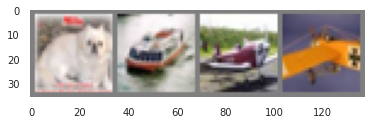

  dog  ship plane plane


In [222]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [223]:
images.shape

torch.Size([4, 3, 32, 32])

In [224]:
images[0]

tensor([[[0.8980, 0.7647, 0.7490,  ..., 0.7255, 0.7569, 0.8196],
         [0.7961, 0.5843, 0.4980,  ..., 0.5529, 0.5922, 0.6784],
         [0.7176, 0.4431, 0.3569,  ..., 0.3804, 0.4196, 0.5922],
         ...,
         [0.5765, 0.3333, 0.2157,  ..., 0.8039, 0.8745, 0.8980],
         [0.6784, 0.4980, 0.4510,  ..., 0.6941, 0.8667, 0.8824],
         [0.8667, 0.7333, 0.7569,  ..., 0.7882, 0.8510, 0.9059]],

        [[0.8980, 0.7725, 0.7255,  ..., 0.6941, 0.7333, 0.8039],
         [0.7961, 0.5922, 0.4667,  ..., 0.4902, 0.5373, 0.6549],
         [0.6627, 0.3647, 0.2235,  ..., 0.2784, 0.3569, 0.5451],
         ...,
         [0.5451, 0.2863, 0.1843,  ..., 0.7490, 0.8275, 0.8824],
         [0.6706, 0.4588, 0.3882,  ..., 0.6471, 0.8431, 0.8588],
         [0.4902, 0.4902, 0.5294,  ..., 0.3804, 0.4824, 0.5059]],

        [[0.8980, 0.7569, 0.7176,  ..., 0.6863, 0.7255, 0.8118],
         [0.7961, 0.5608, 0.4353,  ..., 0.4745, 0.5137, 0.6627],
         [0.6627, 0.3490, 0.2000,  ..., 0.2549, 0.3255, 0.

## テキストデータを扱う

In [0]:
import pandas as pd

In [226]:
df = pd.DataFrame({'text':['I like kaggle very much',
                           'I do not like kaggle',
                           'I do really love machine learning']})
df

text
0            I like kaggle very much
1               I do not like kaggle
2  I do really love machine learning

In [227]:
from sklearn.feature_extraction.text import  CountVectorizer

vectorizer = CountVectorizer(token_pattern=u'(?u)\\b\\w+\\b')
bag = vectorizer.fit_transform(df['text'])
bag.toarray()

array([[0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1],
       [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0],
       [1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0]])

In [229]:
print(vectorizer.vocabulary_)

{'i': 1, 'like': 4, 'kaggle': 2, 'very': 10, 'much': 7, 'do': 0, 'not': 8, 'really': 9, 'love': 5, 'machine': 6, 'learning': 3}


In [231]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer = CountVectorizer(token_pattern=u'(?u)\\b\\w+\\b')
transformer = TfidfTransformer()

tf = vectorizer.fit_transform(df['text'])
tfidf = transformer.fit_transform(tf)
print(tfidf.toarray())

[[0.         0.31544415 0.40619178 0.         0.40619178 0.
  0.         0.53409337 0.         0.         0.53409337]
 [0.43306685 0.33631504 0.43306685 0.         0.43306685 0.
  0.         0.         0.56943086 0.         0.        ]
 [0.34261996 0.26607496 0.         0.45050407 0.         0.45050407
  0.45050407 0.         0.         0.45050407 0.        ]]


In [233]:
from gensim.models import word2vec

sentences = [d.split() for d in df['text']]
model = word2vec.Word2Vec(sentences, size=10, min_count=1, window=2, seed=7)

ERROR! Session/line number was not unique in database. History logging moved to new session 62


In [234]:
model.wv['like']

array([ 0.0412062 , -0.02886636,  0.02103533,  0.00548949, -0.0351446 ,
       -0.00738941, -0.02014552,  0.04390772,  0.01834782,  0.03540131],
      dtype=float32)

In [235]:
model.wv.most_similar('like')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



[('machine', 0.4242241382598877),
 ('not', 0.3965189456939697),
 ('do', 0.37001487612724304),
 ('really', 0.36153003573417664),
 ('learning', -0.0022108331322669983),
 ('kaggle', -0.13018617033958435),
 ('very', -0.15521341562271118),
 ('love', -0.18065182864665985),
 ('I', -0.32416725158691406),
 ('much', -0.5412983298301697)]

In [236]:
df['text'][0].split()

['I', 'like', 'kaggle', 'very', 'much']

In [237]:
import numpy as np

wordvec = np.array([model.wv[word] for word in df['text'][0].split()])
wordvec

array([[-0.02743699, -0.039786  , -0.04602381,  0.02890608, -0.04198941,
        -0.03290583,  0.02438222, -0.041879  , -0.04815627, -0.03333012],
       [ 0.0412062 , -0.02886636,  0.02103533,  0.00548949, -0.0351446 ,
        -0.00738941, -0.02014552,  0.04390772,  0.01834782,  0.03540131],
       [ 0.0483243 , -0.03579833, -0.01811118, -0.03783101, -0.02558223,
        -0.00364086,  0.04630178, -0.03788123, -0.04868606, -0.03469689],
       [-0.03242363,  0.04924013,  0.00647005, -0.00077954,  0.01634388,
        -0.00632284, -0.04966407, -0.00867638,  0.03762331,  0.01640911],
       [-0.0280443 , -0.0121598 , -0.03287721, -0.0235444 ,  0.01031553,
         0.02665315,  0.0250859 , -0.04565854, -0.00493403,  0.02236468]],
      dtype=float32)

In [238]:
np.mean(wordvec, axis=0)

array([ 0.00032511, -0.01347407, -0.01390136, -0.00555187, -0.01521137,
       -0.00472116,  0.00519206, -0.01803749, -0.00916105,  0.00122962],
      dtype=float32)

In [239]:
np.max(wordvec, axis=0)

array([0.0483243 , 0.04924013, 0.02103533, 0.02890608, 0.01634388,
       0.02665315, 0.04630178, 0.04390772, 0.03762331, 0.03540131],
      dtype=float32)